# Modeling

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings

warnings.filterwarnings('ignore')

crashes_cleaned = pd.read_csv('../data/crashes_cleaned.csv')

In [2]:
!pip install imblearn


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


## Using SMOTE to Address Sample Imbalance

In [3]:
from imblearn.over_sampling import SMOTE

le = LabelEncoder()

crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE'] = le.fit_transform(crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE'])

X = crashes_cleaned.drop(columns = ['CRASH_RECORD_ID', 'Unnamed: 0', 'PRIM_CONTRIBUTORY_CAUSE', 'LONGITUDE', 'LATITUDE', 
                                    'WEATHER_CONDITION_CLEAR', 'ALIGNMENT_STRAIGHT AND LEVEL', 'ROADWAY_SURFACE_COND_SNOW OR SLUSH', 
                                    'ROADWAY_SURFACE_COND_WET', 'ROAD_DEFECT_UNKNOWN', 'MOST_SEVERE_INJURY_NO INDICATION OF INJURY'])
y = crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
ss = StandardScaler()

ss.fit(X_train_resampled)

X_train_scaled = ss.transform(X_train_resampled)
X_test_scaled = ss.transform(X_test)

## Fitting Model

In [4]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)

model.fit(X_train_scaled, y_train_resampled)

LogisticRegression(max_iter=1000, multi_class='multinomial')

## Predicitons and Evaluation Metrics

In [5]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, log_loss, f1_score, ConfusionMatrixDisplay, roc_auc_score

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
#auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.7036692104596911
Precision: [0.76923705 0.6521217  0.15384615 0.25948179 0.25704225 0.44934334]
Recall: [0.82390854 0.62513955 0.09491904 0.1864041  0.19363395 0.33722895]
F1 score: [0.79563473 0.63834562 0.11740331 0.21695447 0.22087746 0.38529601]


## Confusion Matrix

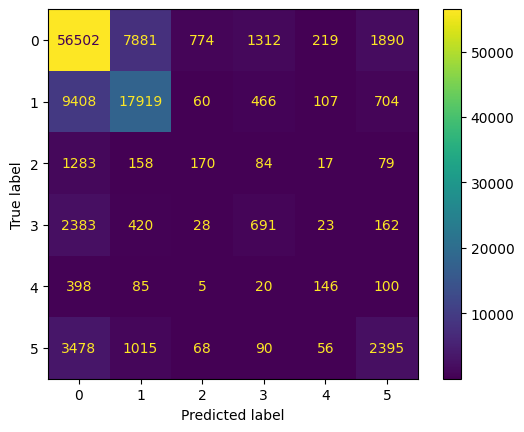

In [6]:
cf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cf, display_labels=None)

disp.plot()

## Evaluating Coefficients for Feature Reduction

In [7]:
coefficients = model.coef_

# Get the intercepts for each class
intercepts = model.intercept_

class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

# Create a DataFrame to display the coefficients
coefficients_df = pd.DataFrame(coefficients, columns=crashes_cleaned.drop(columns = ['CRASH_RECORD_ID', 'Unnamed: 0', 'PRIM_CONTRIBUTORY_CAUSE', 'LONGITUDE', 'LATITUDE', 
                                    'WEATHER_CONDITION_CLEAR', 'ALIGNMENT_STRAIGHT AND LEVEL', 'ROADWAY_SURFACE_COND_SNOW OR SLUSH', 
                                    'ROADWAY_SURFACE_COND_WET', 'ROAD_DEFECT_UNKNOWN', 'MOST_SEVERE_INJURY_NO INDICATION OF INJURY']).columns, index=class_names)

# Display the coefficients
print("Coefficients:")
print(coefficients_df)

# Create a DataFrame to display the intercepts
intercepts_df = pd.DataFrame(intercepts, columns=['Intercept'], index=class_names)

# Display the intercepts
print("\nIntercepts:")
print(intercepts_df)

Coefficients:
         POSTED_SPEED_LIMIT  CRASH_TYPE  INTERSECTION_RELATED_I  \
Class 0           -0.088236    0.588163                0.320461   
Class 1           -0.083984    0.203968                0.479764   
Class 2            0.025504   -0.250996               -0.206208   
Class 3           -0.049586   -0.341876               -0.238174   
Class 4            0.204537   -0.122775               -0.391479   
Class 5           -0.008235   -0.076484                0.035635   

         NOT_RIGHT_OF_WAY_I  HIT_AND_RUN_I    DAMAGE  NUM_UNITS  CRASH_HOUR  \
Class 0            0.071330       0.392629  0.142815   0.206827    0.042917   
Class 1            0.014546       0.256497  0.173340   0.302747    0.049968   
Class 2           -0.019578      -0.547967 -0.068052   0.064294   -0.011136   
Class 3            0.015161       0.726545  0.037139   0.151633   -0.037797   
Class 4           -0.056179      -0.363642 -0.230730  -0.500059   -0.014757   
Class 5           -0.025280      -0.464063

In [8]:
(coefficients_df.max()).max()

2.7748164548858028

In [9]:
threshold = ((coefficients_df.max()).max())/60

col_names = list(coefficients_df.columns[coefficients_df.max() > threshold])

filtered_coef_df = coefficients_df[col_names]
filtered_coef_df

col_names.append('PRIM_CONTRIBUTORY_CAUSE')

crashes_cleaned_2 = crashes_cleaned[col_names]
crashes_cleaned_2

,POSTED_SPEED_LIMIT,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,...,SEC_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"SEC_CONTRIBUTORY_CAUSE_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",SEC_CONTRIBUTORY_CAUSE_WEATHER,ROAD_DEFECT_NO DEFECTS,ROAD_DEFECT_OTHER,"ROAD_DEFECT_RUT, HOLES",MOST_SEVERE_INJURY_INCAPACITATING INJURY,MOST_SEVERE_INJURY_NONINCAPACITATING INJURY,"MOST_SEVERE_INJURY_REPORTED, NOT EVIDENT",PRIM_CONTRIBUTORY_CAUSE
0,30,1,0,0,1,2,4,14,7,7,...,0,0,0,1,0,0,0,0,0,0
1,30,1,0,0,1,2,2,17,3,9,...,0,0,0,1,0,0,0,0,0,0
2,30,0,0,0,0,2,3,18,1,7,...,0,0,0,1,0,0,0,0,0,0
3,30,1,0,0,1,2,2,11,4,9,...,0,0,0,1,0,0,0,0,0,0
4,30,1,1,0,1,2,2,15,7,9,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442377,30,1,0,0,1,0,2,12,4,9,...,0,0,0,1,0,0,0,0,0,0
442378,30,0,0,0,0,2,2,7,3,7,...,0,0,0,1,0,0,0,0,1,3
442379,30,1,0,0,1,2,2,19,7,12,...,0,0,0,0,0,0,0,0,0,0
442380,30,1,0,0,1,1,2,8,5,2,...,0,0,0,1,0,0,0,0,0,1


## Modeling With New Dataset

In [10]:
X2 = crashes_cleaned_2.drop(columns = ['PRIM_CONTRIBUTORY_CAUSE'])
y2 = crashes_cleaned_2['PRIM_CONTRIBUTORY_CAUSE']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)
smote2 = SMOTE()
X2_train_resampled, y2_train_resampled = smote2.fit_resample(X2_train, y2_train)
ss2 = StandardScaler()

ss2.fit(X2_train_resampled)

X2_train_scaled = ss2.transform(X2_train_resampled)
X2_test_scaled = ss2.transform(X2_test)


## Fitting New Model

In [11]:
model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)

model2.fit(X2_train_scaled, y2_train_resampled)

y2_pred = model2.predict(X2_test_scaled)
accuracy2 = accuracy_score(y2_test, y2_pred)
precision2 = precision_score(y2_test, y2_pred, average=None)
recall2 = recall_score(y2_test, y2_pred, average=None)
f12 = f1_score(y2_test, y2_pred, average=None)
#auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')

print('Accuracy:', accuracy2)
print('Precision:', precision2)
print('Recall:', recall2)
print('F1 score:', f12)

Accuracy: 0.683704654779558
Precision: [0.78351472 0.62109517 0.11574508 0.22875226 0.13631634 0.4145741 ]
Recall: [0.7710468  0.66057147 0.13556531 0.20669935 0.18741059 0.35988032]
F1 score: [0.77723076 0.64022537 0.12487361 0.21716738 0.15783133 0.38529591]


## Confusion Matrix

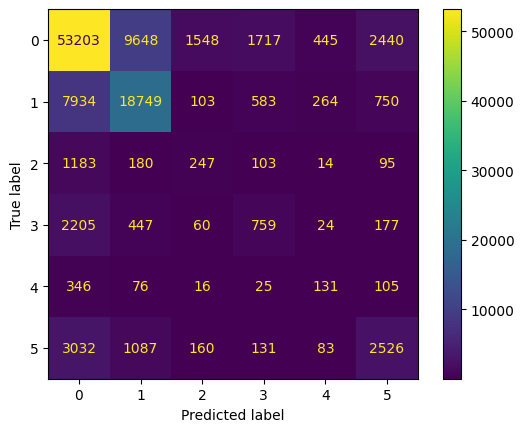

In [12]:
cf2 = confusion_matrix(y2_test, y2_pred)
disp2 = ConfusionMatrixDisplay(cf2, display_labels=None)

disp2.plot()

## Modeling on Binned Features

In [13]:
crashes_cleaned_binned = pd.read_csv('../data/crashes_cleaned_binned.csv')
crashes_cleaned_binned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442382 entries, 0 to 442381
Data columns (total 59 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Unnamed: 0                                         442382 non-null  int64  
 1   POSTED_SPEED_LIMIT                                 442382 non-null  int64  
 2   CRASH_TYPE                                         442382 non-null  int64  
 3   INTERSECTION_RELATED_I                             442382 non-null  int64  
 4   NOT_RIGHT_OF_WAY_I                                 442382 non-null  int64  
 5   HIT_AND_RUN_I                                      442382 non-null  int64  
 6   DAMAGE                                             442382 non-null  int64  
 7   PRIM_CONTRIBUTORY_CAUSE                            442382 non-null  int64  
 8   NUM_UNITS                                          442382 non-null  int64 

In [14]:
X = crashes_cleaned_binned.drop(columns = ['PRIM_CONTRIBUTORY_CAUSE'])
y = crashes_cleaned_binned['PRIM_CONTRIBUTORY_CAUSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
ss = StandardScaler()

ss.fit(X_train_resampled)

X_train_scaled = ss.transform(X_train_resampled)
X_test_scaled = ss.transform(X_test)

## Fitting Model and Evaluation Metrics

In [15]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)

model.fit(X_train_scaled, y_train_resampled)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, log_loss, f1_score, ConfusionMatrixDisplay, roc_auc_score

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
#auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.6866794459112445
Precision: [0.74134534 0.6701488  0.12542662 0.24768946 0.11111111 0.41578695]
Recall: [0.84499402 0.5326542  0.08207705 0.18073914 0.23607427 0.24401577]
F1 score: [0.78978357 0.59354287 0.09922376 0.20898316 0.15110357 0.30754215]


## Confusion Matrix

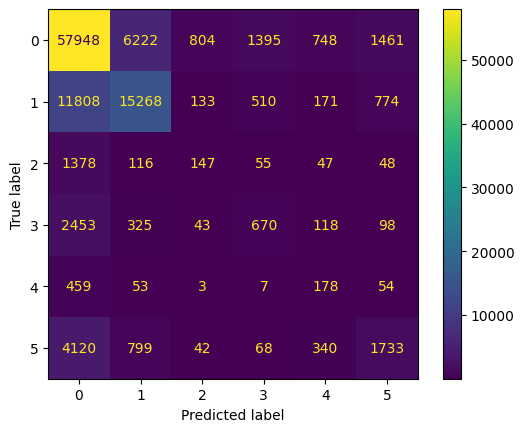

In [16]:
cf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cf, display_labels=None)

disp.plot()

# GRID SEARCH FOR OPTIMAIZATION
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
    'class_weight': [None, 'balanced'],
    'multi_class': ['ovr', 'multinomial'],
    'tol': [1e-4, 1e-3, 1e-2],
}

# Create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs = -2)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the final model with the best hyperparameters
final_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', **best_params)
final_model.fit(X_train_scaled, y_train)

# Evaluate the final model on the test set
test_accuracy = final_model.score(X_test, y_test)


# Decision Tree Model

In [17]:
crashes_cleaned = pd.read_csv('../data/crashes_cleaned.csv', index_col = 0)

label = LabelEncoder()

crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE'] = label.fit_transform(crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE'])
crashes_cleaned

X = crashes_cleaned.drop(columns = ['PRIM_CONTRIBUTORY_CAUSE', 'CRASH_RECORD_ID'])
y = crashes_cleaned['PRIM_CONTRIBUTORY_CAUSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

## Fit Model

In [18]:

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

## Cross Validation

In [19]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

def cross_validation(X_train, y_train, num_split=10):
    score_train_list = []
    score_val_list = []

    for train_index, valid_index in KFold(n_splits=num_split).split(X_train):
        # Train and validation splitting
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        # Create/fit decision tree classifier
        clf = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 39, min_samples_split = 50, random_state =10)
        clf.fit(X_train_fold, y_train_fold)

        # Evaluate performance
        accuracy_train = clf.score(X_train_fold, y_train_fold)
        accuracy_val = clf.score(X_val_fold, y_val_fold)
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)

    return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

result = cross_validation(X_train, y_train, num_split=10)
print(result)

{'train': 0.7459877147850692, 'validation': 0.7360196556824128}


## Plot Decision Tree

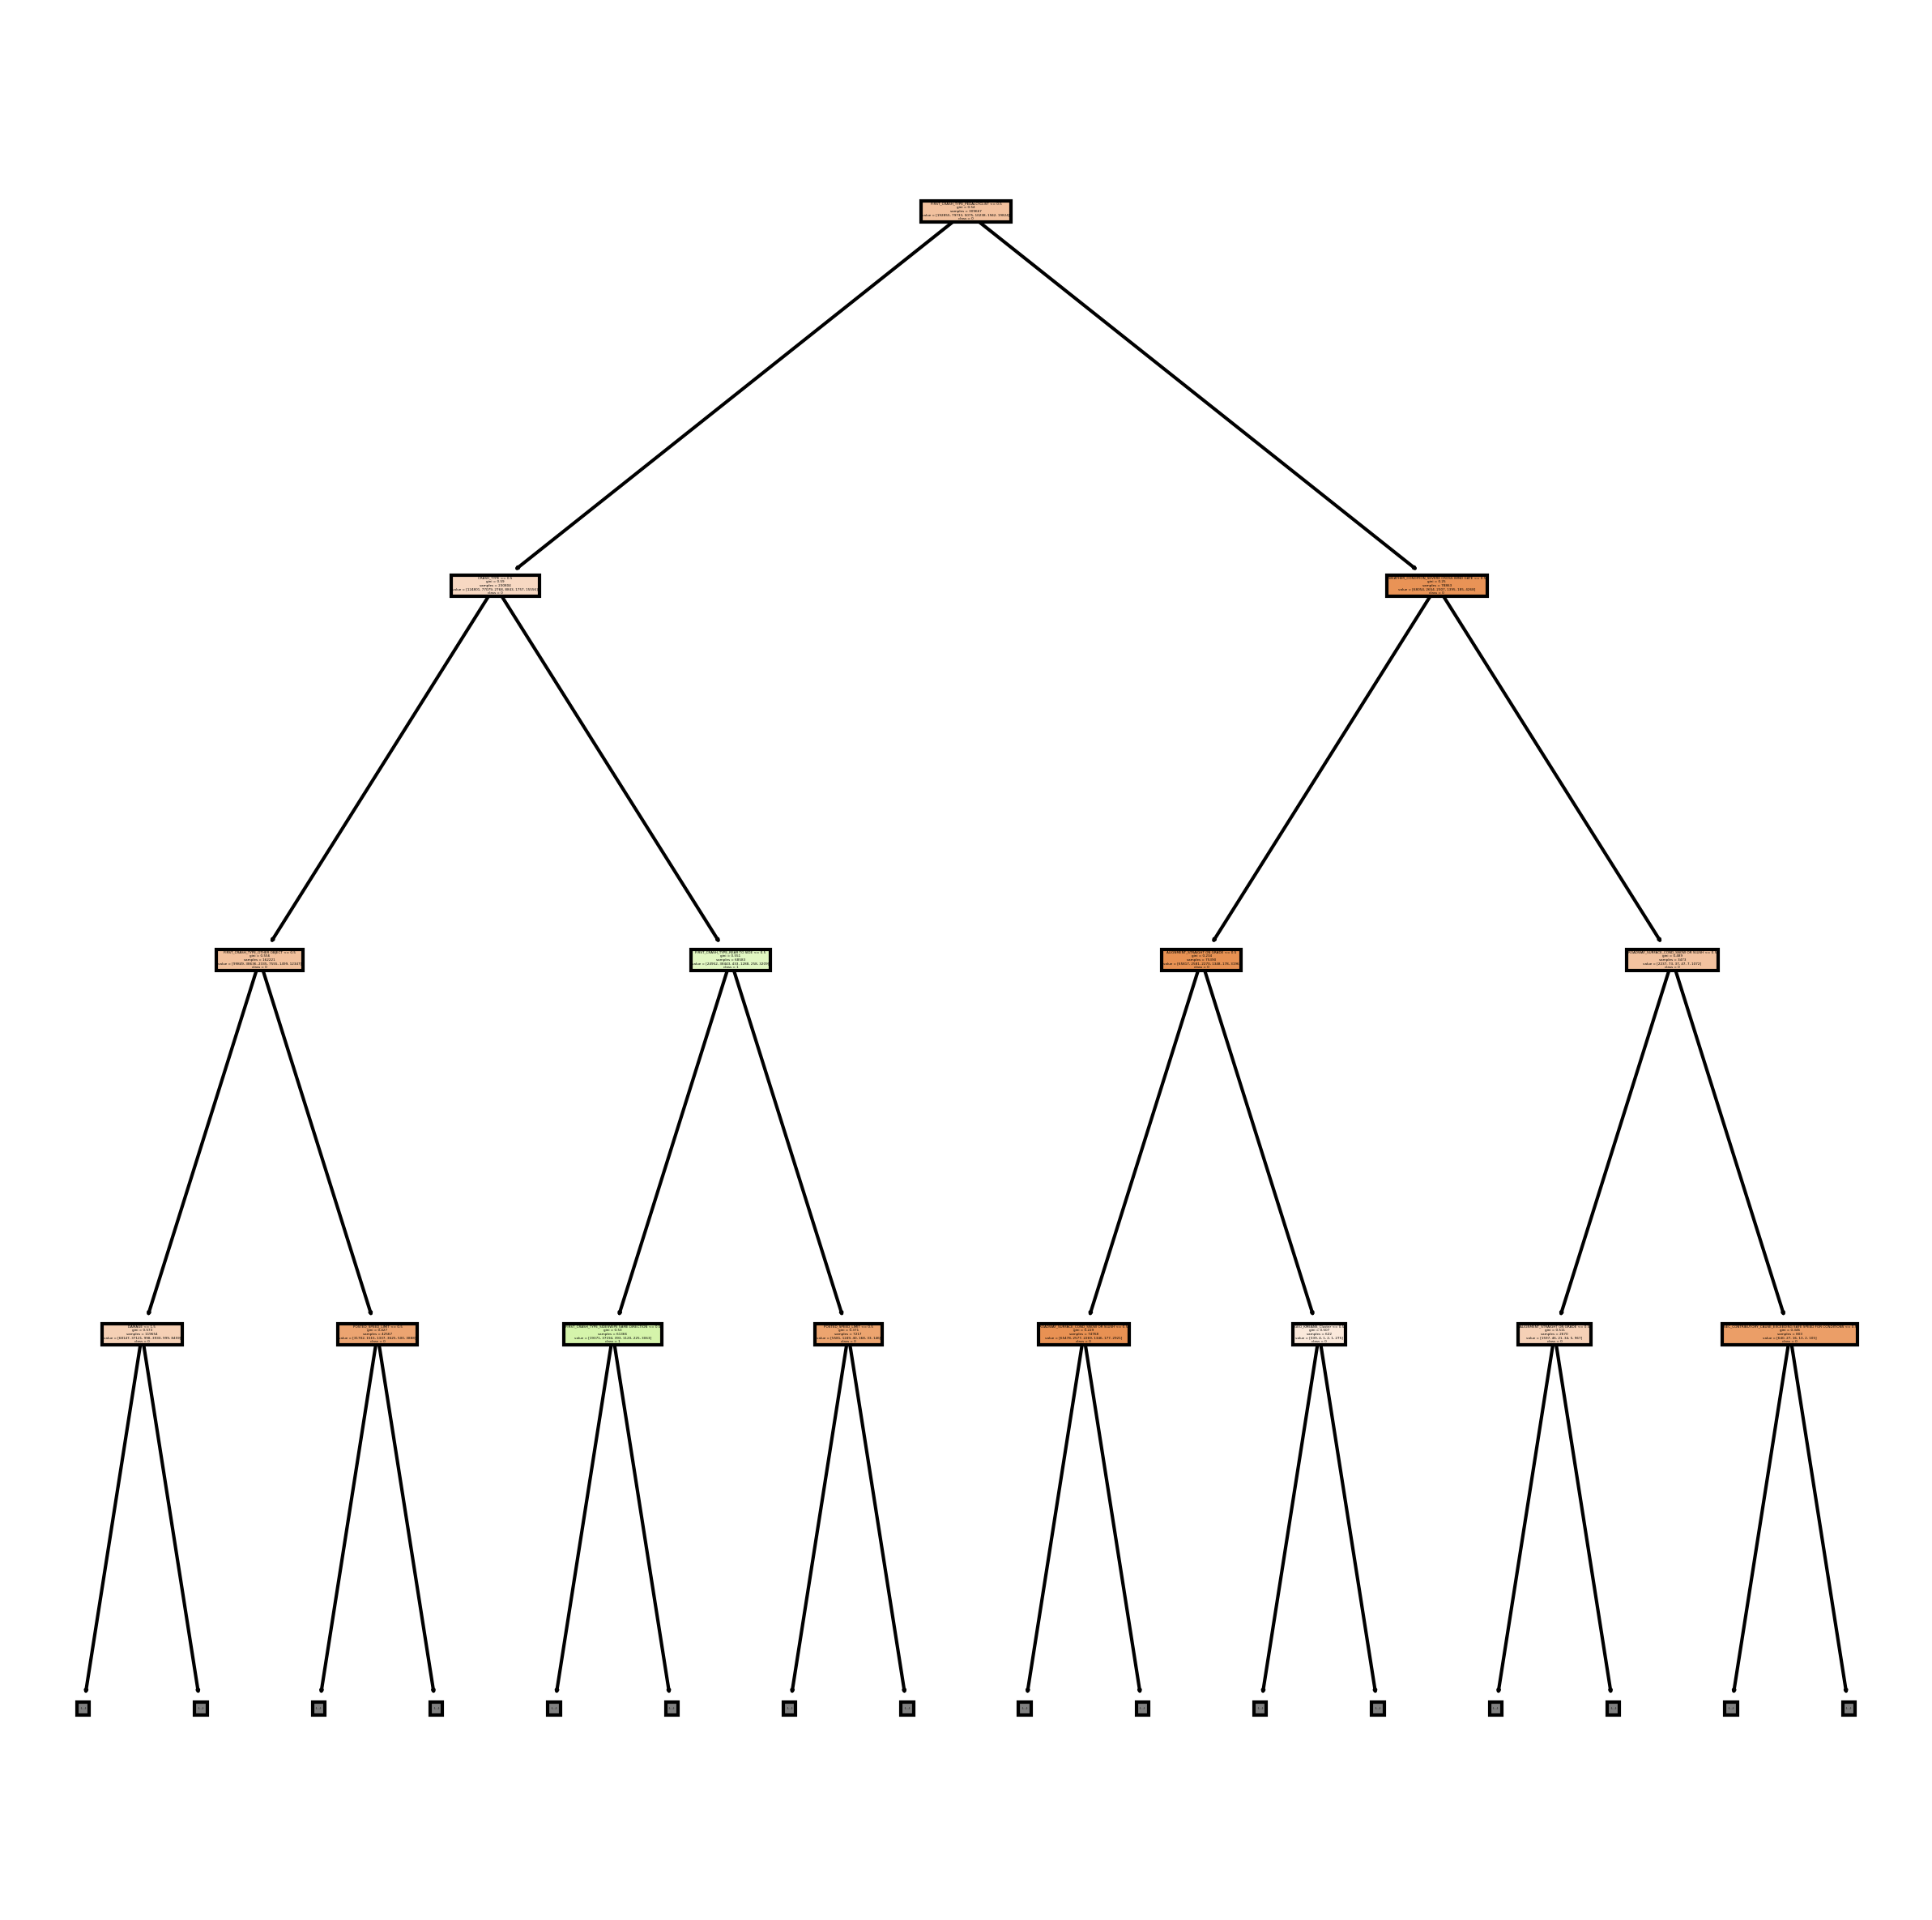

In [20]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (10,10), dpi=300)
plot_tree(clf,
           max_depth = 3,
           feature_names = crashes_cleaned.columns, 
           class_names=np.unique(y).astype('str'),
           filled = True,
           ax = axes)
plt.show()

## Accuracy Score

In [21]:
y_preds = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_preds))

Accuracy: 0.6258448555174623


## Criterion = Entropy

In [22]:
clf_entropy = DecisionTreeClassifier(criterion='entropy')

clf_entropy.fit(X_train, y_train)

y_preds_entropy = clf_entropy.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_preds_entropy))

Accuracy: 0.6247824285122254


## Scaling

In [23]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# try out both models on scaled data
clf.fit(X_train_sc, y_train)
y_preds_sc_gini = clf.predict(X_test_sc)
print('Accuracy gini scaled:', accuracy_score(y_test, y_preds_sc_gini))

clf_entropy.fit(X_train_sc, y_train)
y_preds_sc_entropy = clf_entropy.predict(X_test_sc)
print('Accuracy entropy scaled:', accuracy_score(y_test, y_preds_sc_entropy))

Accuracy gini scaled: 0.6272086802546811
Accuracy entropy scaled: 0.6256489469916738


## Balance Weights

In [24]:
clf_w = DecisionTreeClassifier(class_weight='balanced')
clf_w.fit(X_train, y_train)
y_preds_w = clf_w.predict(X_test)
print('Accuracy weighted:', accuracy_score(y_test, y_preds_w))

Accuracy weighted: 0.6210978412387447


## Oversampling with SMOTE

In [25]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


## Model with SMOTE

In [26]:
clf_resamp = DecisionTreeClassifier()

clf_resamp.fit(X_train_resampled, y_train_resampled)

y_preds_resamp = clf_resamp.predict(X_test)
print('Accuracy weighted:', accuracy_score(y_test, y_preds_resamp))

y_pred_proba_resamp = clf_resamp.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba_resamp,  multi_class='ovo')
print('AUC Score:', auc_score)

Accuracy weighted: 0.5984478016802923
AUC Score: 0.5938253303315746


## Tuning Hyperparameters

#### Max Depth

In [27]:
depth_list = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for depth in depth_list:
    
    clf_hyper = DecisionTreeClassifier(max_depth = depth, min_samples_split = 10)
    clf_hyper.fit(X_train, y_train)
    y_preds = clf_hyper.predict(X_test)
    print('Accuracy depth', depth,':', accuracy_score(y_test, y_preds))
    
    y_pred_proba = clf.predict_proba(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba,  multi_class='ovo')
    print('AUC Score', depth, ':', auc_score)

Accuracy depth 3 : 0.6805485438722073
AUC Score 3 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 5 : 0.6949327506310515
AUC Score 5 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 7 : 0.7087669065290284
AUC Score 7 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 9 : 0.7253061070715443
AUC Score 9 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 11 : 0.732185510304035
AUC Score 11 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 13 : 0.7333911012319633
AUC Score 13 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 15 : 0.733647289304148
AUC Score 15 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 17 : 0.7311155483554986
AUC Score 17 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 19 : 0.7266774667520627
AUC Score 19 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy depth 21 : 0.7223900840146178
AUC Score 21 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


#### Minimum Number of Samples Needed to Split

In [28]:
minsamp_list = [15, 17, 19, 21, 23, 25, 27, 35, 37, 39, 41, 43, 45, 50]

for minsamp in minsamp_list:
    
    clf_hyper = DecisionTreeClassifier(max_depth = 15, min_samples_split = minsamp)
    clf_hyper.fit(X_train, y_train)
    y_preds = clf_hyper.predict(X_test)
    print('Accuracy ', minsamp,':', accuracy_score(y_test, y_preds))
    
y_pred_proba = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba,  multi_class='ovo')
print('AUC Score', minsamp, ':', auc_score)

Accuracy  15 : 0.7341069208454206
Accuracy  17 : 0.734385713747504
Accuracy  19 : 0.7346795765361865
Accuracy  21 : 0.7345665523866933
Accuracy  23 : 0.7345288776701955
Accuracy  25 : 0.7346343668763893
Accuracy  27 : 0.7345138077835964
Accuracy  35 : 0.7345062728402969
Accuracy  37 : 0.734672041592887
Accuracy  39 : 0.7346795765361865
Accuracy  41 : 0.73495836943827
Accuracy  43 : 0.7349508344949705
Accuracy  45 : 0.7350337188712655
Accuracy  50 : 0.7352371623403534
AUC Score 50 : 0.5089192068265515


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


#### Minimum Number of Samples Needed in a Leaf

In [29]:
minsamp_list = [37, 39, 41, 43, 45, 50, 100]

for minsamp in minsamp_list:
    
    clf_hyper = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = minsamp, min_samples_split = 50)
    clf_hyper.fit(X_train, y_train)
    y_preds = clf_hyper.predict(X_test)
    print('Accuracy ', minsamp,':', accuracy_score(y_test, y_preds))
    
y_pred_proba = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba,  multi_class='ovo')

Accuracy  37 : 0.7361714953094978
Accuracy  39 : 0.7359906566703086
Accuracy  41 : 0.7360735410466036
Accuracy  43 : 0.7361262856497005
Accuracy  45 : 0.7357344685981237
Accuracy  50 : 0.7348152055155784
Accuracy  100 : 0.7356365143352296


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


## Combination of Best Hyperparameters

In [30]:
clf_hyper = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 39, min_samples_split = 50)
clf_hyper.fit(X_train, y_train)
y_preds = clf_hyper.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_preds))

Accuracy: 0.7359906566703086


## Final Model Scores

In [31]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

print('Accuracy:', accuracy_score(y_test, y_preds))
print('Precision:', precision_score(y_test, y_preds, average=None))
print('Recall:', recall_score(y_test, y_preds, average=None))
print('f1 score:', f1_score(y_test, y_preds, average=None))

Accuracy: 0.7359906566703086
Precision: [0.75853611 0.68398608 0.36986301 0.45470383 0.90322581 0.6193126 ]
Recall: [0.89126776 0.63535477 0.01264045 0.05886333 0.09929078 0.22556032]
f1 score: [0.8195626  0.65877414 0.02444545 0.10423323 0.17891374 0.33068251]


## Bagging Classifier

In [32]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=10, max_samples=0.5, max_features=0.5)
bagging.fit(X_train, y_train)
bagging.score(X_test,y_test)

y_pred = bagging.predict(X_test)

print('Accuracy weighted:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average=None))
print('Recall:', recall_score(y_test, y_pred, average=None))
print('f1 score:', f1_score(y_test, y_pred, average=None))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy weighted: 0.6930866895226614
Precision: [0.71206297 0.63366531 0.32142857 0.35983264 0.84042553 0.58973439]
Recall: [0.89502174 0.47072702 0.00842697 0.03879116 0.09338061 0.19587506]
f1 score: [0.79312787 0.54017648 0.01642336 0.07003257 0.16808511 0.29407553]


In [33]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 39, min_samples_split = 50, random_state= 15),
                            n_estimators=20, max_samples=0.5, max_features=0.5)
bagging.fit(X_train, y_train)
bagging.score(X_test,y_test)

y_pred = bagging.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.7204460686433335
Precision: [0.72367243 0.70383443 0.         0.71111111 0.91666667 0.75586557]
Precision weighted: 0.7097385827133299
Recall: [0.92959469 0.51112665 0.         0.00721696 0.09101655 0.14210777]
Recall weighted: 0.7204460686433335
f1 score: [0.81380926 0.59219762 0.         0.0142889  0.1655914  0.23923733]
f1 score weighted: 0.6762238923567964


## Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_list = [20, 30, 40, 50]

for forest_not_tree in forest_list:

    clf = RandomForestClassifier(n_estimators=forest_not_tree, max_depth=None,  min_samples_split=2, random_state=0)
    clf.fit(X_train, y_train)
    clf.score(X_test,y_test)
    y_pred = clf.predict(X_test)
    
    print('-----------------------------------------')
    print('n_estimators', forest_not_tree)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
    print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
    print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
    print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
    print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
    print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

-----------------------------------------
n_estimators 20
Accuracy: 0.7320423463813435
Precision: [0.75384269 0.67950526 0.37272727 0.46911197 0.80172414 0.62861736]
Precision weighted: 0.7113562048724744
Recall: [0.8914494  0.61767447 0.01919476 0.05480379 0.10992908 0.23307105]
Recall weighted: 0.7320423463813435
f1 score: [0.81689156 0.64711626 0.03650935 0.09814216 0.19334719 0.34005914]
f1 score weighted: 0.702286991154901
-----------------------------------------
n_estimators 30
Accuracy: 0.73495836943827
Precision: [0.7565682  0.68242325 0.38947368 0.4884696  0.82905983 0.6366298 ]
Precision weighted: 0.7154038773302014
Recall: [0.89166737 0.62865548 0.0173221  0.05254849 0.11465721 0.23330949]
Recall weighted: 0.73495836943827
f1 score: [0.81858102 0.65443685 0.03316898 0.09488902 0.20145379 0.34147618]
f1 score weighted: 0.7052107672264856
-----------------------------------------
n_estimators 40
Accuracy: 0.7378216478920996
Precision: [0.75844457 0.68641368 0.39772727 0.54648

In [35]:
forest_list = [60,70,80]

for forest_not_tree in forest_list:

    clf = RandomForestClassifier(n_estimators=forest_not_tree, max_depth=None,  min_samples_split=2, random_state=0)
    clf.fit(X_train, y_train)
    clf.score(X_test,y_test)
    y_pred = clf.predict(X_test)
    
    print('-----------------------------------------')
    print('n_estimators', forest_not_tree)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
    print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
    print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
    print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
    print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
    print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

-----------------------------------------
n_estimators 60
Accuracy: 0.7396752439437894
Precision: [0.75985483 0.68813559 0.46341463 0.565      0.80530973 0.6611074 ]
Precision weighted: 0.7240692265069582
Recall: [0.89496119 0.63858791 0.01779026 0.05096978 0.10756501 0.23628994]
Recall weighted: 0.7396752439437894
f1 score: [0.82189267 0.66243655 0.0342651  0.09350434 0.18978102 0.34814685]
f1 score weighted: 0.7096593869883027
-----------------------------------------
n_estimators 70
Accuracy: 0.740051991108767
Precision: [0.76028525 0.68863345 0.45205479 0.56756757 0.8125     0.66003976]
Precision weighted: 0.7243471440970851
Recall: [0.89469478 0.6403938  0.01544944 0.05209743 0.10756501 0.23748212]
Recall weighted: 0.740051991108767
f1 score: [0.82203197 0.66363815 0.02987777 0.09543483 0.18997912 0.34928985]
f1 score weighted: 0.7101242893962982
-----------------------------------------
n_estimators 80
Accuracy: 0.7403006442376521
Precision: [0.76032216 0.68903222 0.47142857 0.56

In [36]:
forest_list = [90, 100, 110, 120]

for forest_not_tree in forest_list:

    clf = RandomForestClassifier(n_estimators=forest_not_tree, max_depth=None,  min_samples_split=2, random_state=0)
    clf.fit(X_train, y_train)
    clf.score(X_test,y_test)
    y_pred = clf.predict(X_test)
    
    print('-----------------------------------------')
    print('n_estimators', forest_not_tree)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
    print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
    print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
    print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
    print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
    print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

-----------------------------------------
n_estimators 90
Accuracy: 0.7405191575933391
Precision: [0.76036568 0.68975139 0.42647059 0.58139535 0.81578947 0.66189684]
Precision weighted: 0.7248749477376882
Recall: [0.89539713 0.64083071 0.01357678 0.05074425 0.10992908 0.23712446]
Recall weighted: 0.7405191575933391
f1 score: [0.82237534 0.66439173 0.02631579 0.09334163 0.19375    0.34916177]
f1 score weighted: 0.7104215687190427
-----------------------------------------
n_estimators 100
Accuracy: 0.7410239987944091
Precision: [0.76078907 0.69047395 0.44594595 0.57480315 0.80701754 0.66410684]
Precision weighted: 0.7255022822017643
Recall: [0.89574831 0.64202493 0.01544944 0.04939107 0.10874704 0.23712446]
Recall weighted: 0.7410239987944091
f1 score: [0.82277108 0.66536865 0.02986425 0.09096573 0.19166667 0.34946851]
f1 score weighted: 0.7109043715856239
-----------------------------------------
n_estimators 110
Accuracy: 0.7411294880006027
Precision: [0.76093018 0.69017168 0.45205479 

#### Best Number of Estimators Model

In [41]:
clf_final = RandomForestClassifier(n_estimators=120, max_depth=None,  min_samples_split=2, random_state=0)
clf_final.fit(X_train, y_train)
clf_final.score(X_test,y_test)
y_pred = clf_final.predict(X_test)

print('-----------------------------------------')
print('n_estimators')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average=None,zero_division=0))
print('Precision weighted:', precision_score(y_test, y_pred, average='weighted',zero_division=0))
print('Recall:', recall_score(y_test, y_pred, average=None, zero_division=0))
print('Recall weighted:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
print('f1 score:', f1_score(y_test, y_pred, average=None,zero_division=0))
print('f1 score weighted:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

-----------------------------------------
n_estimators
Accuracy: 0.7415062351655803
Precision: [0.76115901 0.69069877 0.42857143 0.58776596 0.81981982 0.6704698 ]
Precision weighted: 0.7264278441750555
Recall: [0.89579675 0.6434813  0.01544944 0.04984213 0.10756501 0.23819742]
Recall weighted: 0.7415062351655803
f1 score: [0.82300782 0.6662545  0.02982377 0.09189189 0.19017764 0.35151302]
f1 score weighted: 0.7114308539580916


#### Confusion Matrix

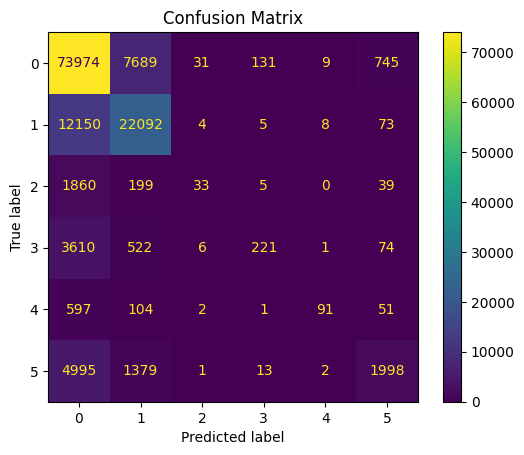

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

#### ROC-AUC Curve

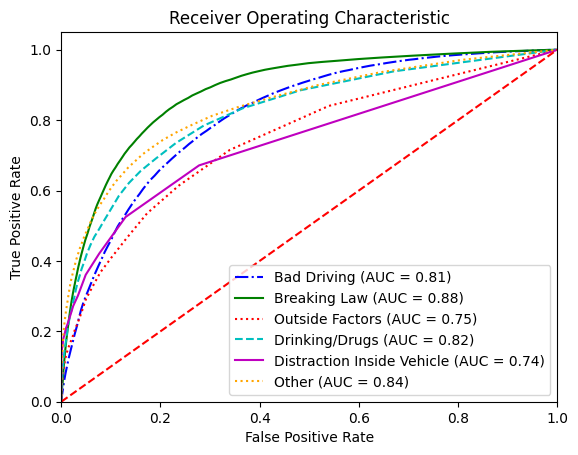

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_scores = clf_final.predict_proba(X_test)
n_classes = len(clf_final.classes_)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=clf_final.classes_)

# Calculate the false positive rate, true positive rate, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Class names 
class_names = ['Bad Driving', 'Breaking Law', 'Outside Factors', 'Drinking/Drugs', 'Distraction Inside Vehicle', 'Other']

# Plot the ROC curves
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'orange']  # List of colors for each class
linestyles = ['-.', '-', ':', '--', '-', ':']  # List of line styles for each class

for class_name, i in zip(class_names, range(n_classes)):
    color = colors[i % len(colors)]  # Cycle through the colors for each class
    linestyle = linestyles[i % len(linestyles)]  # Cycle through the line styles for each class
    plt.plot(fpr[i], tpr[i], color=color, linestyle=linestyle, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../images/roc_randomforest.png', facecolor='w', transparent=False)
plt.show()


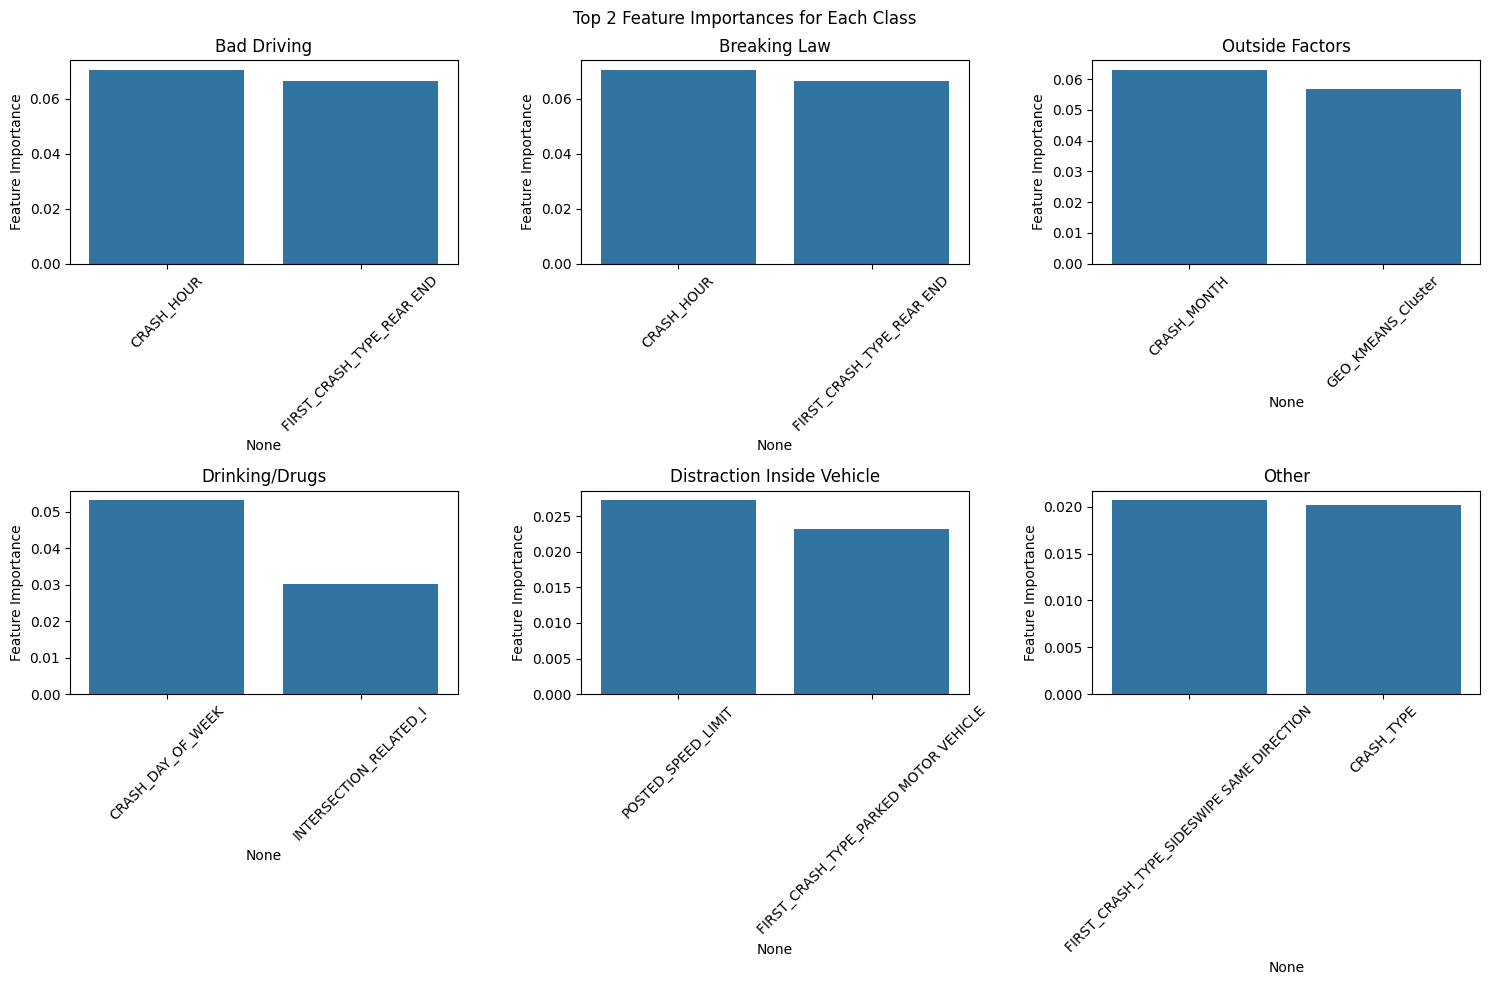

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names
class_names = ['Bad Driving', 'Breaking Law', 'Outside Factors', 'Drinking/Drugs', 'Distraction Inside Vehicle', 'Other']

# Print the feature importances
feature_importances = clf_final.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a figure with three columns and two rows
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Top 2 Feature Importances for Each Class")

# Iterate over each class
for class_label, ax in zip(range(6), axes.flatten()):
    # Filter the sorted feature importances and names for the current class
    class_sorted_importances = sorted_importances[class_label*2 : (class_label+1)*2]
    class_sorted_feature_names = sorted_feature_names[class_label*2 : (class_label+1)*2]

    if class_label == 0:
        # For class 0, select the 3rd and 4th feature instead
        class_sorted_importances = sorted_importances[class_label*2 + 2 : (class_label+1)*2 + 2]
        class_sorted_feature_names = sorted_feature_names[class_label*2 + 2 : (class_label+1)*2 + 2]

    # Create the bar plot for the current class
    sns.barplot(x=class_sorted_feature_names, y=class_sorted_importances, ax=ax )
    ax.set_title(class_names[class_label])  # Set the title using class_names
#     ax.set_xlabel("Feature Name")
    ax.set_ylabel("Feature Importance")

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('../images/feature_importance.png', facecolor='w', transparent=False)
plt.show()